In [2]:
import nltk
nltk.download('brown')
nltk.download('universal_tagset')
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import pprint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix
from nltk.tokenize import sent_tokenize
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
nltk_dataset = list(nltk.corpus.brown.tagged_sents(tagset='universal'))
import seaborn as sns

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [28]:
import re

In [36]:
for word in nltk_dataset:
    # Adding a extra dummy tag "-" and a word "^" to indicate the start of the sentence
  word.insert(0, ("^", "-"))


In [4]:
print(nltk_dataset[:5])

[[('^', '-'), ('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')], [('^', '-'), ('The', 'DET'), ('jury', 'NOUN'), ('further', 'ADV'), ('said', 'VERB'), ('in', 'ADP'), ('term-end', 'NOUN'), ('presentments', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('City', 'NOUN'), ('Executive', 'ADJ'), ('Committee', 'NOUN'), (',', '.'), ('which', 'DET'), ('had', 'VERB'), ('over-all', 'ADJ'), ('charge', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('election', 'NOUN'), (',', '.'), ('``', '.'), ('deserves', 'VERB'), ('the', 'DET'), ('praise', 'NOUN'), ('and', 'CONJ'), ('thanks', 'NOUN'), ('of', 'ADP')

In [5]:
TAGS = set()

for sent in nltk_dataset:
        for word, tag in sent:
            TAGS.add(tag)
TAGS = sorted(list(TAGS))

print(TAGS)

N_TAGS = len(TAGS)

['-', '.', 'ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRON', 'PRT', 'VERB', 'X']


In [6]:
id2tag = lambda ind : TAGS[ind]
tagmap = {TAGS[ind]:ind for ind in range(N_TAGS)}
tag2id = lambda ind : tagmap[ind]

In [7]:
def log(x):
    # Used for calculating log probabilities and handles the error when the input is 0
    if x == 0:
        return -np.inf
    else:
        return np.log(x)

In [8]:
average = lambda x : sum(x) / len(x)

In [9]:
folds = []
length = len(nltk_dataset)
split_it = length // 5
random.shuffle(nltk_dataset)
for start in range(0, length, split_it):
    end = min(start + split_it, length)
    fold = nltk_dataset[start : end]
    folds.append(fold)

In [10]:
# Avg cm
avg_cm = 0 # ignoring the dummy tag added at the start of each sentence

# Initialize average metrics
avg_acc = 0
avg_prec = 0
avg_rec = 0


# Average tagwise metrics
avg_prec_tagwise = 0
avg_rec_tagwise = 0
avg_f1_tagwise = 0


# Error scores
avg_f1 = 0
avg_f05 = 0
avg_f2 = 0

In [11]:
def Matrices(tf, ef, tag_freq):
    # Builds the transition and emmission matrices from the frequency matrices while applying smoothing 

    # Initialize
    transmission_matrix = np.zeros((N_TAGS, N_TAGS))
    emission_matrix = np.zeros((N_TAGS, N_VOCAB))

    alpha = 0.0000001

    for i in range(N_TAGS):

        # Build the transition matrix
        for j in range(N_TAGS):
            tagi = id2tag(i)
            tagj = id2tag(j)
            transmission_matrix[i, j] = (tf[(tagi, tagj)] + alpha) / (tag_freq[tagi] + alpha*N_TAGS)

        # Build the emission matrix
        for j in range(N_VOCAB):
            tagi = id2tag(i)
            wordj = id2word(j)
            emission_matrix[i, j] = (ef[(tagi, wordj)] + alpha) / (tag_freq[tagi] + alpha*N_VOCAB)

    return  emission_matrix, transmission_matrix

In [12]:
def train(data):

    tag_freq = defaultdict(int)
    tf = defaultdict(int) 
    ef = defaultdict(int)

    for sent in data:
        prev_tag = "-" 
        for word, tag in sent:
            tf[(prev_tag, tag)] += 1 # auto-init to 0 when key doesn't exit
            ef[(tag, word)] += 1 # each word has a corresponding tag
            tag_freq[tag] += 1
            prev_tag = tag # update prev tag


    emission_matrix, transmission_matrix = Matrices(tf, ef, tag_freq)
    return transmission_matrix, emission_matrix

In [30]:
def viterbi(tm, em, sent):

    n_sent = len(sent)
    tag_pred = [] 
    tags_sample = []
    best_probs = np.zeros((n_sent, N_TAGS))
    ## Edge case
    for i in range(N_TAGS):
        best_probs[0, i] = log(tm[0, i]) + log(em[i, word2id(sent[0])])

    best_tags  = np.zeros((n_sent, N_TAGS))
    pmax = -np.inf

    # Using Dynamic Programming
    for i in range(1, n_sent):

        w_prev = sent[i - 1]
        w_cur = sent[i]

        for j in range(N_TAGS):
            pmax = -np.inf
            best_tag = None
            for k in range(N_TAGS):        
                p = best_probs[i - 1, k] + log(tm[k, j])  # We are adding instead o multiplying since it's log
                if p > pmax:
                    pmax = p
                    best_tag = k

            try:
                wid = word2id(w_cur)
            except KeyError: # handles KeyError
                wid = -1 # word not in vocab

            if wid != -1:
                best_probs[i, j] = pmax + log(em[j, wid]) 
            else:
                best_probs[i, j] = pmax + log(em.min())

            best_tags[i, j] = best_tag
            
    pmax = -np.inf

    end_tag = None
    for i in range(N_TAGS):
        if best_probs[-1, i] > pmax:
            pmax = best_probs[-1, i]
            end_tag = i
    tag_pred.append(end_tag)
    tags_sample.append(TAGS[end_tag])

    end = end_tag # init
    for i in range(n_sent - 1, 0, -1):
        end = int(best_tags[i, end])
        tag_pred.append(end)
        tags_sample.append(TAGS[end])

    tags_sample.reverse()    
    tag_pred.reverse()
    return tag_pred, list(zip(sent, tags_sample))

In [17]:
def evaluate(data, tm, em):
    # Evaluates the trained HMM model on the data

    tags_true = []
    tags_pred = []

    for data in tqdm(data):
        sent = [ind[0] for ind in data]
        t_true = [tag2id(ind[1]) for ind in data[1:]] # We don't have to take the "-" tag
        t_pred, list_sample = viterbi(tm, em, sent)
        tags_true = tags_true + t_true
        tags_pred = tags_pred + t_pred
        
    return tags_true, tags_pred  

In [18]:
for fv in range(5):

    # Separate out the validation fold
    val_data = folds[fv]

    # Concatenate the training folds
    train_data = []
    for ft in range(5):
        if ft != fv:
            train_data += folds[ft]

    # Update vocab based on training data (these variables are used globally)
    VOCAB = set()
    for sent in train_data:
        for word, tag in sent:
            VOCAB.add(word)
    VOCAB = sorted(list(VOCAB))

    N_VOCAB = len(VOCAB)
    id2word = lambda i : VOCAB[i]
    wordmap = {VOCAB[i]:i for i in range(N_VOCAB)}
    word2id = lambda i : wordmap[i]

    # Train
    tm, em = train(train_data)

    # Validate  
    tags_true, tags_pred = evaluate(val_data, tm, em)

    # Compute metrics

    metric_labels = [i+1 for i in range(N_TAGS - 1)] # ignore the first dummy tag '-'

    cm = confusion_matrix(tags_true, tags_pred, normalize = "true", labels = metric_labels)

    acc = accuracy_score(tags_true, tags_pred)

    prec = precision_score(tags_true, tags_pred, average = None, labels = metric_labels)
    rec = recall_score(tags_true, tags_pred, average = None, labels = metric_labels)

    f1 = f1_score(tags_true, tags_pred, average = None, labels = metric_labels)
    f05 = fbeta_score(tags_true, tags_pred, beta = 0.5, average = "macro", labels = metric_labels)
    f2 = fbeta_score(tags_true, tags_pred, beta = 2, average = "macro", labels = metric_labels)

    # Updating global avg values
    avg_acc += acc
    avg_prec += average(prec)
    avg_rec += average(rec)

    # Updating tagwise metrics
    avg_prec_tagwise += prec
    avg_rec_tagwise += rec
    avg_f1_tagwise += f1

    # Updating error function
    avg_f1 += average(f1)
    avg_f05 += f05
    avg_f2 += f2

    # Update cm
    avg_cm += cm

  0%|          | 0/11468 [00:00<?, ?it/s]

  0%|          | 0/11468 [00:00<?, ?it/s]

  0%|          | 0/11468 [00:00<?, ?it/s]

  0%|          | 0/11468 [00:00<?, ?it/s]

  0%|          | 0/11468 [00:00<?, ?it/s]

In [19]:
  # Average over the number of folds

avg_cm /= 5

avg_acc /= 5
avg_prec /= 5
avg_rec /= 5
avg_f1 /= 5
avg_f05 /= 5
avg_f2 /= 5

avg_prec_tagwise /= 5
avg_rec_tagwise /= 5
avg_f1_tagwise /= 5

Tag-wise precision:
.: 0.996, ADJ: 0.921, ADP: 0.950, ADV: 0.909, CONJ: 0.993, DET: 0.968, NOUN: 0.962, NUM: 0.971, PRON: 0.954, PRT: 0.908, VERB: 0.972, X: 0.812, 
Tag-wise recall:
.: 1.000, ADJ: 0.911, ADP: 0.968, ADV: 0.896, CONJ: 0.995, DET: 0.987, NOUN: 0.953, NUM: 0.912, PRON: 0.985, PRT: 0.907, VERB: 0.952, X: 0.506, 
Tag-wise F1:
.: 0.998, ADJ: 0.916, ADP: 0.959, ADV: 0.902, CONJ: 0.994, DET: 0.977, NOUN: 0.958, NUM: 0.941, PRON: 0.969, PRT: 0.907, VERB: 0.962, X: 0.620, 
Accuracy: 0.9592742212878406
Avg. precision: 0.9429709002282667
Avg. recall: 0.9142664270937051
Avg. f_0.5: 0.9346071375808126
Avg. f1: 0.9252197147711531
Avg. f2: 0.9181357646925681


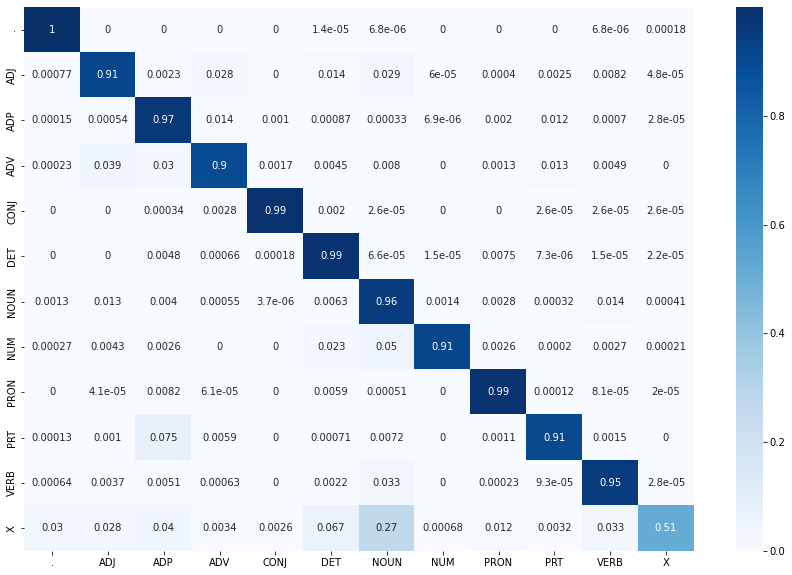

In [20]:
# Final metrics reported

# Tag-wise metrics
print("Tag-wise precision:")
# printClasswise(avg_prec_tagwise)
for i in range(N_TAGS - 1):
    print(f"{TAGS[i+1]}: {avg_prec_tagwise[i]:.3f}", end = ", ")
print()

print("Tag-wise recall:")
# printClasswise(avg_rec_tagwise)
for i in range(N_TAGS - 1):
    print(f"{TAGS[i+1]}: {avg_rec_tagwise[i]:.3f}", end = ", ")
print()


print("Tag-wise F1:")
# printClasswise(avg_f1_tagwise)
for i in range(N_TAGS - 1):
    print(f"{TAGS[i+1]}: {avg_f1_tagwise[i]:.3f}", end = ", ")
print()


# Overall metrics for this fold
print("Accuracy:", avg_acc)
print("Avg. precision:", avg_prec)
print("Avg. recall:", avg_rec)
print("Avg. f_0.5:", avg_f05)
print("Avg. f1:", avg_f1)
print("Avg. f2:", avg_f2)


df_cm = pd.DataFrame(avg_cm, index = [t for t in TAGS[1:]], columns = [t for t in TAGS[1:]])
plt.figure(figsize = (15, 10))
sns.heatmap(df_cm, annot = True, cmap = plt.cm.Blues)
plt.show()

In [35]:
sample = 'I am in, India.'

pat = re.compile(r"([.()!,])")
s = pat.sub(" \\1 ", sample)

useless, predict = viterbi(tm, em, s.split()) 
print(predict)



[('I', 'PRON'), ('am', 'VERB'), ('in', 'ADP'), (',', '.'), ('India', 'NOUN'), ('.', '.')]
